# Classification of Sugarcane Diseases based on Images

## Initial Setup

Examining the train data shows that there are six (6) classes in total:

In [2]:
classes = [
    "Banded_Chlorosis",
    "Brown_Rust",
    "Brown_Spot",
    "Viral",
    "Yellow_Leaf",
    "Healthy",
]

classes.sort()
print(classes)

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Healthy', 'Viral', 'Yellow_Leaf']


## Data Loading and Preprocessing



In [4]:
from pathlib import Path
from pprint import pprint

import keras
import numpy as np
import tensorflow as tf

SEED = 1738  # To make random outcomes reproducible
TRAIN_DIRECTORY = Path("./train")


train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
)


def get_class_distribution(
    dataset, include_class_mappings: bool = False
) -> tuple[dict[int, int], dict[int, str]]:
    class_count = {}
    class_mappings = {}
    class_names = []
    if include_class_mappings:
        class_names = dataset.class_names

    for _, label in dataset:
        label_np = label.numpy()
        if len(class_names) > 0 and class_mappings.get(label_np) is None:
            class_mappings[label_np] = class_names[label_np]
        if class_count.get(label_np) is None:
            class_count[label_np] = 1
            continue
        class_count[label_np] += 1
    return class_count, class_mappings


class_count_train, class_mappings = get_class_distribution(train_ds, True)
class_count_validation, _ = get_class_distribution(validation_ds)

# pprint(class_count_train)
pprint(class_mappings)
# print(f"MINIMUM: {minimum_class}, {minimum_class_count} ")

Found 4314 files belonging to 6 classes.
Using 3452 files for training.
Using 862 files for validation.


2025-05-26 19:28:39.325351: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{np.int32(0): 'Banded_Chlorosis',
 np.int32(1): 'Brown_Rust',
 np.int32(2): 'Brown_Spot',
 np.int32(3): 'Healthy',
 np.int32(4): 'Viral',
 np.int32(5): 'Yellow_Leaf'}


In [5]:
# Compute class weights
# Combine train_ds and val_ds class counts
total_images = sum(class_count_train.values()) + sum(class_count_validation.values())
weights = {}
for key in class_count_train:
    # new_key = np.fromstring(key.strip("[]"), dtype=float, sep=" ").argmax()
    weights[key] = total_images / (
        (class_count_train[key] + class_count_validation[key]) * len(classes)
    )
pprint(weights)
# print(sum(weights.values()))


# Batch the data set for model compatibility
# Prefetch to optimize
def config_performance(dataset: tf.data.Dataset, batch_size):
    dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)

{np.int32(0): 1.695754716981132,
 np.int32(1): 2.549645390070922,
 np.int32(2): 0.4638709677419355,
 np.int32(3): 1.8578811369509043,
 np.int32(4): 1.204355108877722,
 np.int32(5): 0.6694599627560521}


## Method 1: Convolution Neural Network (CNN)

The first method for solving this classification problem is through the use of CNN.

We will be using the Keras and TensorFlow libraries.

First, let us setup the environment and model.

In [4]:
import keras
import matplotlib.pyplot as plt
from keras.api import applications

EPOCHS = 10
DROPOUT_RATE = 0.2
BATCH_SIZE = 128
IMAGE_SIZE = 96

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

models = [
    # applications.InceptionV3,
    # applications.ResNet50V2,
    # applications.ResNet50,
    applications.InceptionResNetV2,
    # applications.MobileNetV3Large,
    # applications.MobileNetV3Small,
]

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=2, mode="auto", restore_best_weights=True # type: ignore
)

for model in models:
    pre_trained_model = model(
        weights="imagenet",
        classes=len(classes),
        include_top=False,  # the fully connected layer at the end
    )

    model_label = f"{pre_trained_model.name}-{EPOCHS}"
    print(model_label)

    for layer in pre_trained_model.layers:
        layer.trainable = False

    transfer_model = keras.models.Sequential(
        [
            # preprocessing layers
            keras.layers.Rescaling(1.0 / 255),
            # data augmentation layers
            # keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
            # keras.layers.RandomBrightness(factor=0.2, seed=SEED),
            # keras.layers.RandomContrast(factor=0.1, seed=SEED),
            pre_trained_model,
            # fully connected
            # keras.layers.Flatten(),
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(1024, activation="relu"),
            keras.layers.Dropout(DROPOUT_RATE),
            keras.layers.Dense(len(classes), activation="softmax"),
        ]
    )

    # transfer_model.summary()

    transfer_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(name="TopK", k=len(classes)//2),
        ],
    )

    history = transfer_model.fit(
        train_ds_optimized,
        epochs=EPOCHS,
        validation_data=validation_ds_optimized,
        class_weight=weights,
        callbacks=[early_stop],
    )

    transfer_model.save(f"./results/models/{model_label}.keras")

Using 3452 files for training.
Using 862 files for validation.
inception_resnet_v2-10
Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - Accuracy: 0.3860 - TopK: 0.7611 - loss: 1.8487 - val_Accuracy: 0.7030 - val_TopK: 0.9513 - val_loss: 0.8505
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - Accuracy: 0.7352 - TopK: 0.9581 - loss: 0.6579 - val_Accuracy: 0.7691 - val_TopK: 0.9838 - val_loss: 0.5713
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1000ms/step - Accuracy: 0.8440 - TopK: 0.9770 - loss: 0.4086 - val_Accuracy: 0.8376 - val_TopK: 0.9954 - val_loss: 0.4285
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 947ms/step - Accuracy: 0.8784 - TopK: 0.9928 - loss: 0.3214 - val_Accuracy: 0.8759 - val_TopK: 0.9919 - val_loss: 0.3827
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 916ms/step - Accuracy: 0.8947 - TopK: 0.9938 - loss: 0.2915 - val_Accuracy: 0.8910 - val_TopK: 0.9942 - val_loss: 0.3128
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 25s 917ms/step - Accuracy: 0.9239 - TopK: 0.9955 - loss: 0.2105 - 

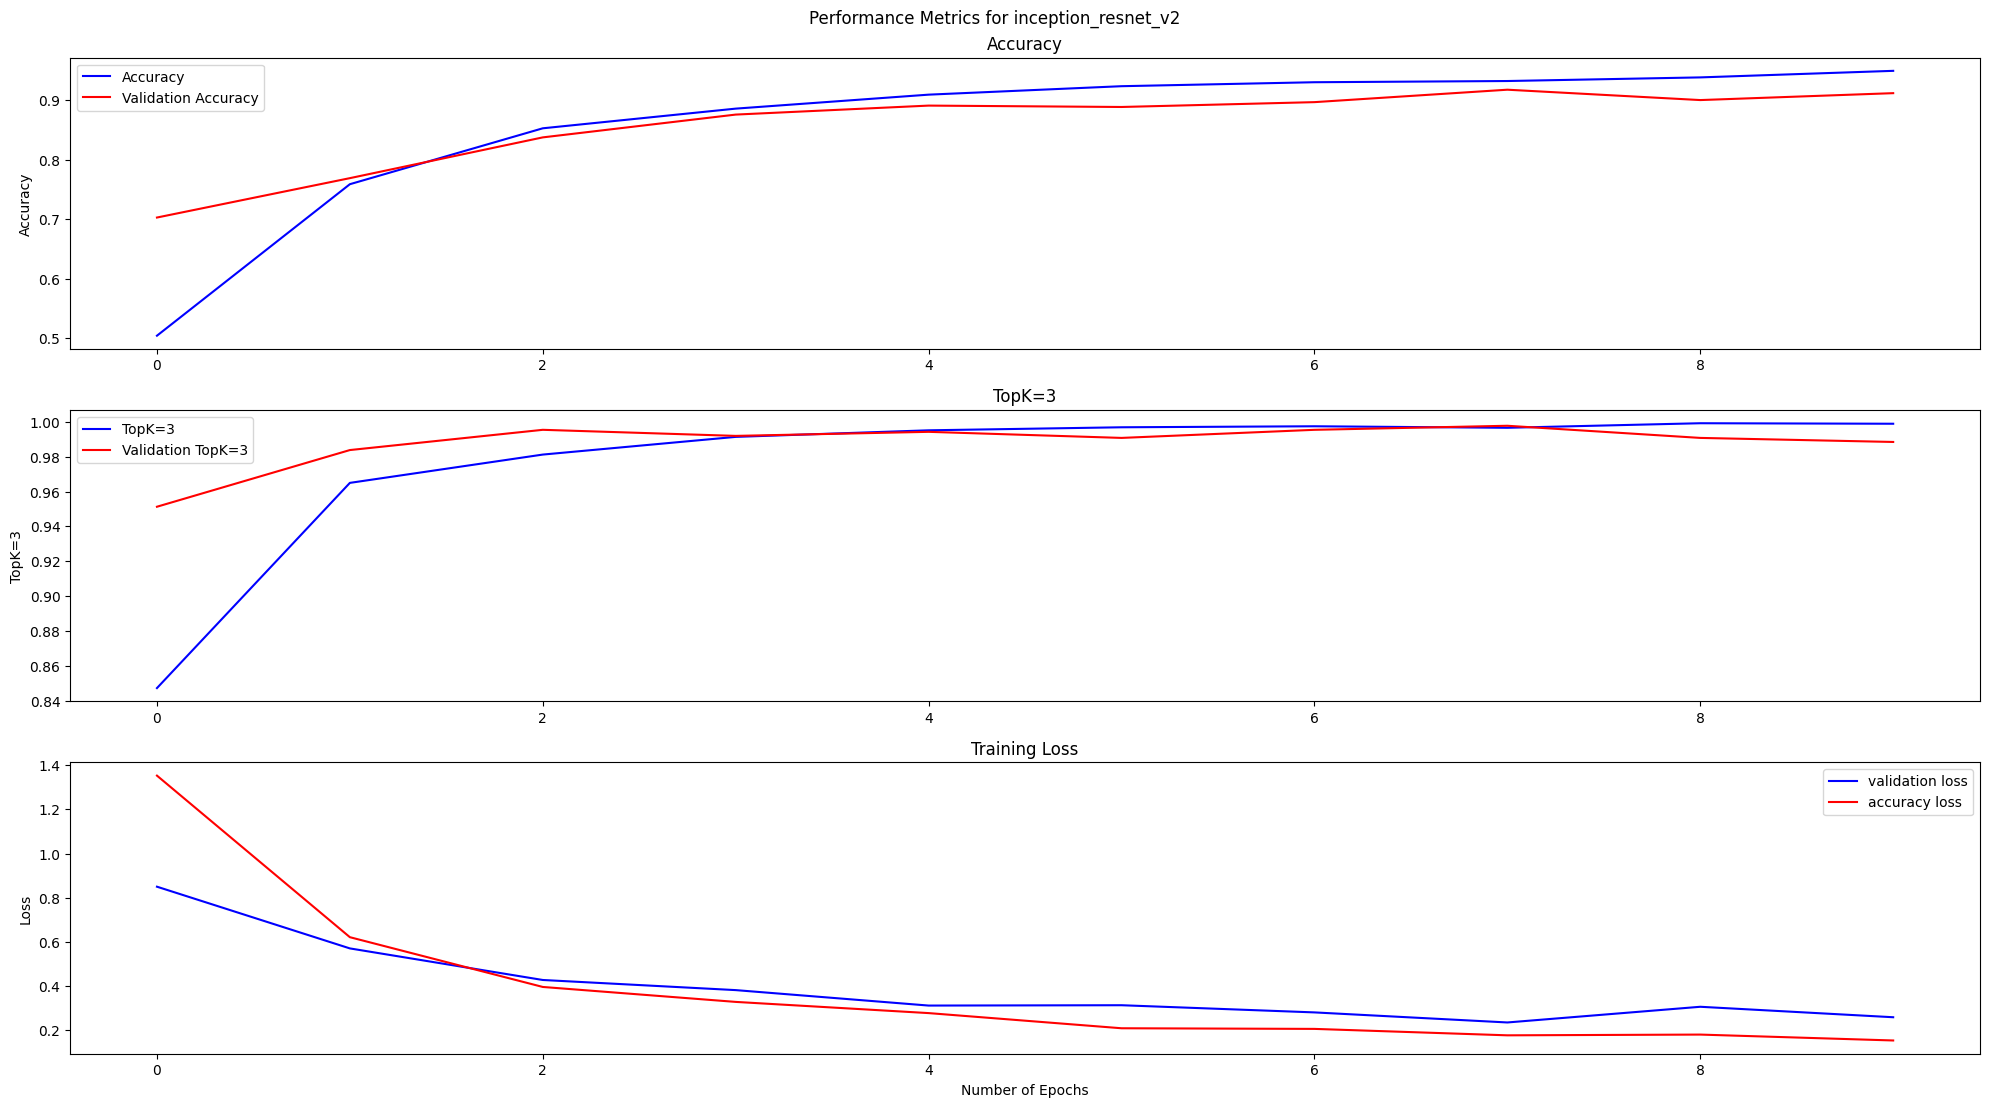

In [5]:
def generate_metric_plots(history):
    fig, axs = plt.subplots(3)
    fig.set_size_inches(w=20, h=11.25)
    fig.set_layout_engine("tight")
    fig.suptitle(f"Performance Metrics for {pre_trained_model.name}")
    axs[0].plot(history.history["Accuracy"], color="b", label="Accuracy")
    axs[0].plot(history.history["val_Accuracy"], color="r", label="Validation Accuracy")
    axs[0].set_title("Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # show the f1_score
    topK = f"TopK={len(classes)//2}"
    axs[1].plot(history.history["TopK"], color="b", label=topK)
    axs[1].plot(history.history["val_TopK"], color="r", label=f"Validation {topK}")
    axs[1].set_title(topK)
    axs[1].set_ylabel(topK)
    axs[1].legend()

    # show the training (and validation) loss
    axs[2].plot(history.history["val_loss"], color="b", label="validation loss")
    axs[2].plot(history.history["loss"], color="r", label="accuracy loss")
    axs[2].set_title("Training Loss")
    axs[2].set_xlabel("Number of Epochs")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    plt.show()
    fig.savefig(f"./results/graph/{model_label}.png")


generate_metric_plots(history)

In [6]:
transfer_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 1, 1, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,225,652 (237.37 MB)

 Trainable params: 2,629,638 (10.03 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

 Optimizer params: 5,259,278 (20.06 MB)

## Method 2: Vision Transformer

In [8]:
import keras_hub

EPOCHS = 3
BATCH_SIZE = 32
IMAGE_SIZE = 64
PRESET = "vit_base_patch16_224_imagenet21k"

# Repeated here to prepare images with correct IMAGE_SIZE
train_ds: tf.data.Dataset
validation_ds: tf.data.Dataset
train_ds, validation_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIRECTORY,
    labels="inferred",
    label_mode="int",
    class_names=classes,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=None,  # type: ignore
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="both",
    pad_to_aspect_ratio=True,
    verbose=False,
)

train_ds_optimized = config_performance(train_ds, BATCH_SIZE)
validation_ds_optimized = config_performance(validation_ds, BATCH_SIZE)

pre_trained_model = keras_hub.models.ViTImageClassifier.from_preset(
    PRESET, num_classes=len(classes), load_weights=False, activation="softmax",
)

vit_model = keras.models.Sequential(
    [
        keras_hub.layers.ViTImageConverter.from_preset(
            PRESET,
            scale=1 / 255,
        ),
        pre_trained_model,
    ]
)

# vit_model.summary()

vit_model.compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),  # type: ignore
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="Accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(name="TopK", k=len(classes)//2),
    ],
)  # type: ignore

history = pre_trained_model.fit(
    train_ds_optimized,
    epochs=EPOCHS,
    validation_data=validation_ds_optimized,
    class_weight=weights,
    callbacks=[early_stop],
)

Using 3452 files for training.
Using 862 files for validation.
Epoch 1/3


/home/ubuntu/CS180-Project/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


  2/108 ━━━━━━━━━━━━━━━━━━━━ 51:28 29s/step - loss: 4.0985 - sparse_categorical_accuracy: 0.2578  

KeyboardInterrupt: 